In [1]:
import rootutils
rootutils.setup_root(".", indicator=".project-root", pythonpath=True, cwd=True)

PosixPath('/home/dgcnz/development/thesis/PART')

In [2]:
cwd = rootutils.find_root()
print(type(cwd))

<class 'pathlib.PosixPath'>


In [3]:
import pytest
from PIL import Image
import torchvision.transforms.v2.functional as TTFv2
import hydra
from omegaconf import OmegaConf
import torch
from src.models.part_vit_module import PARTViTModule
import lightning as L
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from copy import deepcopy
# import plotly dash
import dash


In [4]:


def get_img():
    img = Image.open("artifacts/img.jpg")
    img = img.resize((224, 224))
    patch_size = 16
    num_patches = (224 // patch_size) ** 2
    return img, patch_size, num_patches


def get_cfg():
    with hydra.initialize(version_base=None, config_path="../../configs"):
        cfg = hydra.compose(config_name="train.yaml", overrides=["experiment=overfit_part_im1k_pairdiff_mlp", "model/criterion_fn=l1", "model.sample_mode=offgrid"])
    OmegaConf.register_new_resolver("eval", eval)
    return cfg



def get_train_transform():
    with hydra.initialize(version_base=None, config_path="../../configs"):
        cfg = hydra.compose(config_name="train.yaml", overrides=["experiment=overfit_part_im1k_pairdiff_mlp", "model/criterion_fn=l1", "model.sample_mode=offgrid"])

    transform = hydra.utils.instantiate(cfg.data.train_transform)
    return transform

In [5]:
cfg = get_cfg()   
module: PARTViTModule = hydra.utils.instantiate(cfg.model)
transform = hydra.utils.instantiate(cfg.data.train_transform)
x_raw, _, _ = get_img()
x = transform(x_raw).unsqueeze(0)

/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


tensor(0.2717)
Normal Loss: 0.2665
tensor(0.2717)
Uniform Loss: 0.3060
tensor(0.2717)
Default Loss: 0.4543


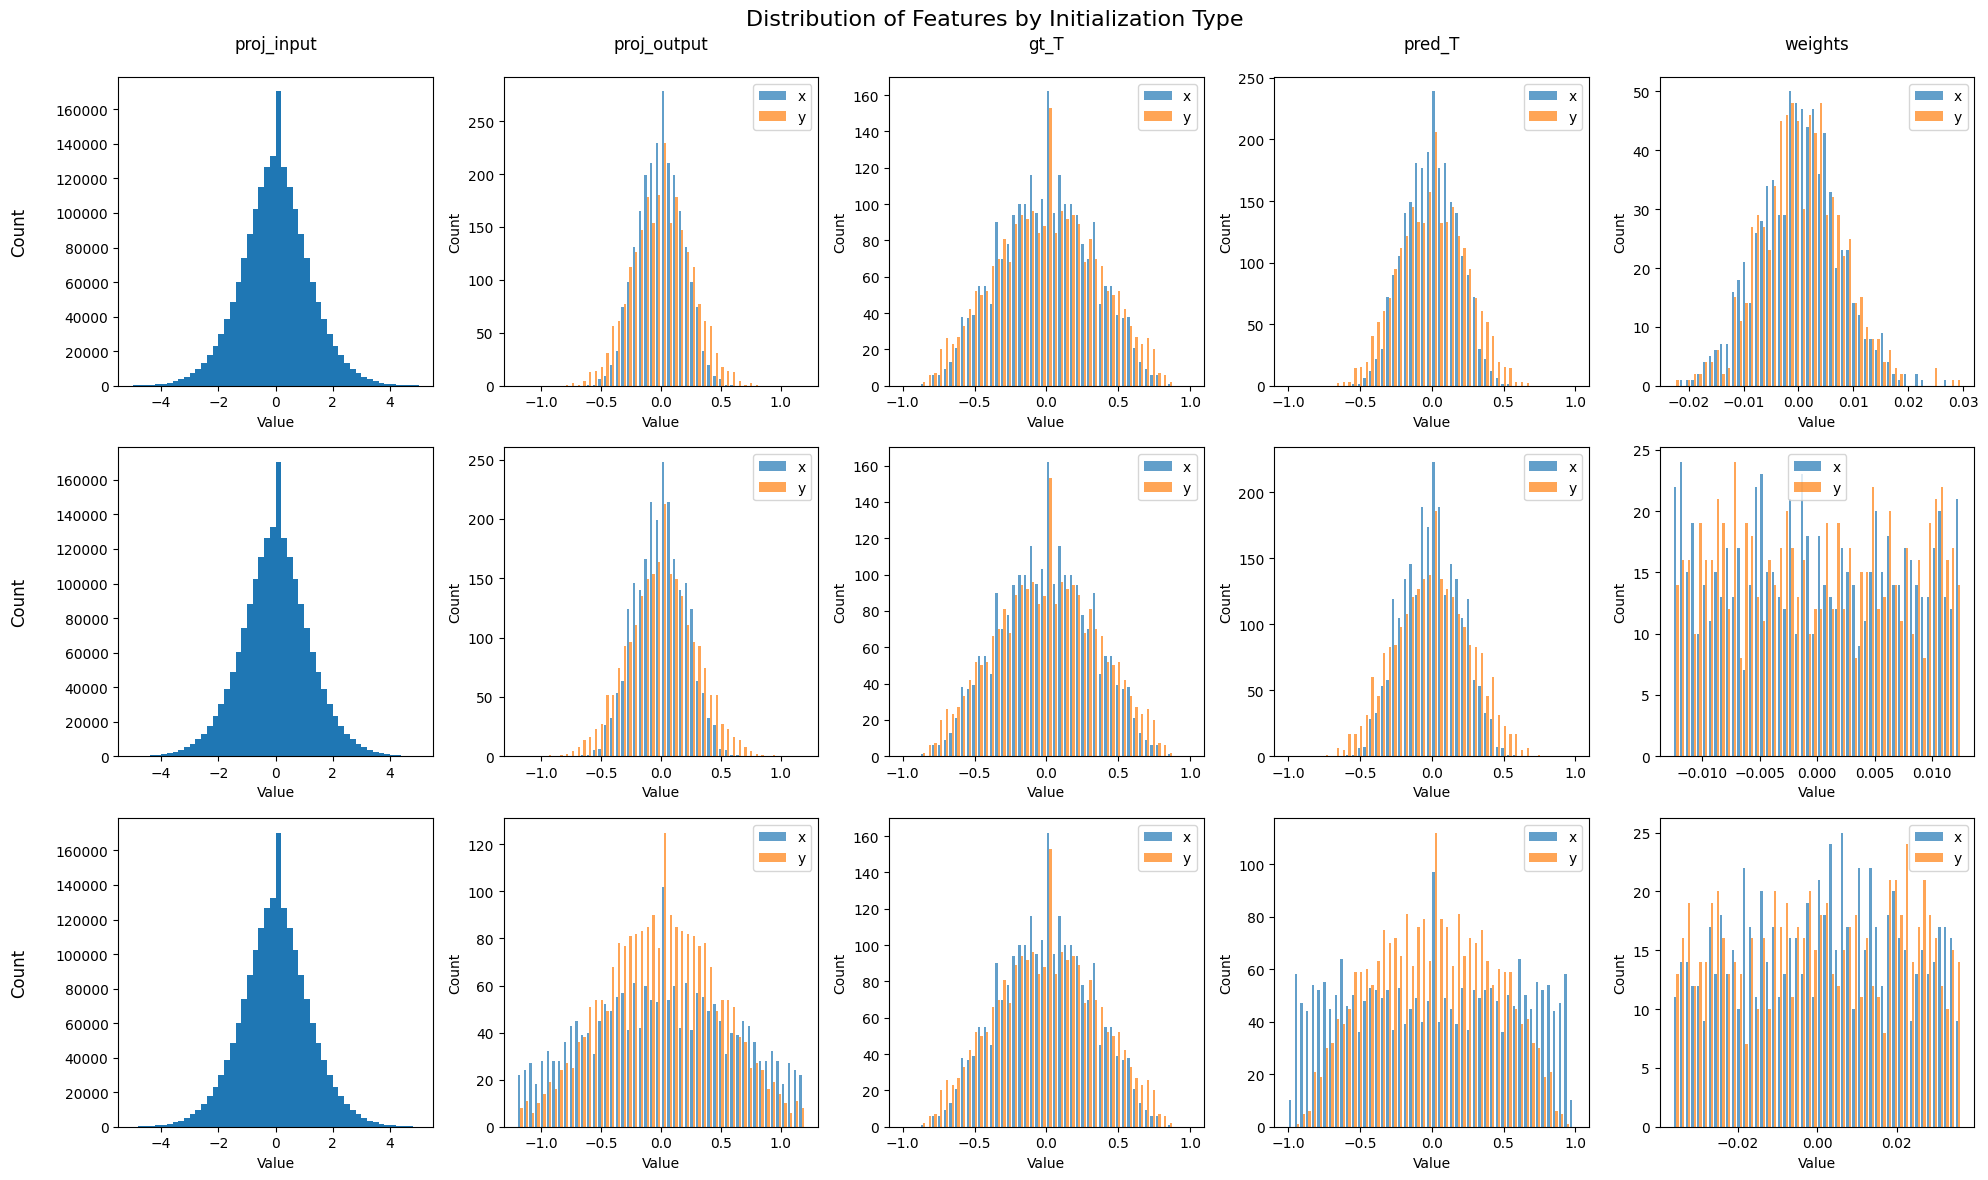

In [8]:
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib 
# jupyter matplotlib
%matplotlib inline

# Function to run experiment and plot results
# Store input features
proj_input_features = []
proj_output_features = []
backbone_features = []

def hook_fn(module, input, output):
    proj_input_features.append(input[0].detach().cpu())
    proj_output_features.append(output.detach().cpu())

def backbone_hook_fn(module, input, output):
    backbone_features.append(output.detach().cpu())

def run_and_plot(init_type, module, fig, axes):
    # Clear stored features
    proj_input_features.clear()
    proj_output_features.clear()
    backbone_features.clear()
    
    # Register hooks
    proj_hook = module.net.head.proj.register_forward_hook(hook_fn)
    backbone_hook = module.net.backbone.register_forward_hook(backbone_hook_fn)

    import math
    torch.manual_seed(0)
    if init_type == "normal":
        fan_in = module.net.head.proj.weight.shape[1]
        std = 1.0 / (5.0 * math.sqrt(fan_in))
        # std = 1.5 / (5.0 * math.sqrt(fan_in))
        module.net.head.proj.weight.data.normal_(0, std)
        # torch.nn.init.kaiming_normal_(module.net.head.proj.weight, mode='fan_out', nonlinearity='tanh')
    elif init_type == "uniform":
        fan_in = module.net.head.proj.weight.shape[1]
        # bound = 1.0/(5.0 * math.sqrt(3.0 * fan_in))
        bound = math.sqrt(3.0/(25.0 * fan_in))  
        # bound = math.sqrt(5.0/(25.0 * fan_in))  
        module.net.head.proj.weight.data.uniform_(-bound, bound)
        # module.net.proj.weight.data.fill_(0)
    else: # default
        pass

    # record memory history torch
    # torch seed
    torch.manual_seed(0)
    with torch.no_grad(): 
        module.eval()
        out = module.model_step({"image": x})
    
    # Remove hooks
    proj_hook.remove()
    backbone_hook.remove()

    # Separate x and y components for selected tensors
    gt_T_y, gt_T_x = module.norm_T(out["gt_T"].detach().cpu())[0].unbind(dim=-1)
    pred_T_y, pred_T_x = module.norm_T(out["pred_T"].detach().cpu())[0].unbind(dim=-1)
    weights_y, weights_x = module.net.head.proj.weight.detach().cpu()
    proj_out_y, proj_out_x = proj_output_features[0][0].unbind(dim=-1)

    # Define the data mapping
    data = {
        'proj_output': (proj_out_x, proj_out_y, -1.2, 1.2),
        'gt_T': (gt_T_x, gt_T_y, -1, 1),
        'pred_T': (pred_T_x, pred_T_y, -1, 1),
        'weights': (weights_x, weights_y, None, None),
    }
    # compute expected loss under l1 regression
    gt_T = module.norm_T(out["gt_T"]).detach().cpu()
    median = gt_T.median().item()
    median_T = torch.full_like(gt_T, median)
    loss = torch.nn.functional.l1_loss(gt_T, median_T)
    print(loss)
    


    # Map initialization type to row index
    row_idx = {'normal': 0, 'uniform': 1, 'default': 2}[init_type]

    # plot proj_input first
    proj_input = proj_input_features[0][0]
    axes[row_idx, 0].hist(proj_input.flatten(), bins=50, range=(-5, 5))
    axes[row_idx, 0].set_xlabel('Value')
    axes[row_idx, 0].set_ylabel('Count')

    # Plot the rest of the data
    for col, (name, (x_data, y_data, mn, mx)) in enumerate(data.items(), start=1):
        axes[row_idx, col].hist([x_data.flatten(), y_data.flatten()], bins=50, 
                               label=['x', 'y'], alpha=0.7, range=(mn, mx) if mn is not None else None)
        axes[row_idx, col].legend()
        axes[row_idx, col].set_xlabel('Value')
        axes[row_idx, col].set_ylabel('Count')

    return out["loss"]

# Create figure and axes
fig, axes = plt.subplots(3, 5, figsize=(20, 12))

# Add a main title
fig.suptitle('Distribution of Features by Initialization Type', fontsize=16)

# Add column labels
col_labels = ['proj_input', 'proj_output', 'gt_T', 'pred_T', 'weights']
for ax, col in zip(axes[0], col_labels):
    ax.set_title(col, fontsize=12, pad=20)

# Add row labels
row_labels = ['Normal', 'Uniform', 'Default']
for ax, row in zip(axes[:, 0], row_labels):
    ax.set_ylabel(row, fontsize=12, rotation=90, labelpad=20)

# Run the experiment and plot results for each initialization type
init_types = ['normal', 'uniform', 'default']
for init_type in init_types:
    module_copy = deepcopy(module)
    loss = run_and_plot(init_type, module_copy, fig, axes)
    print(f"{init_type.capitalize()} Loss: {loss:.4f}")

plt.tight_layout()
plt.show()
